# OD Demand Calibration

### Goal
<font color=red>OD Demand Calibration.</font>

This notebook aims to calibrate OD demand without simulation.

<a id='initialization'></a>

# 0. Initialization

Initialize module imports and set afternoon study intervals.

In [44]:
# Import modules
import datetime
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#####
import calibration_util

# Initialize imports for files in ../utils/*
util_module_path = os.path.abspath(os.path.join('..', 'utils'))
if util_module_path not in sys.path:
    sys.path.append(util_module_path)
import premodeling_folder_utils
import aimsun_folder_utils
import aimsun_input_utils

In [45]:
# Set time intervals of study.
_START_HOUR = 14
_END_HOUR = 20
_TIME_STEP_MINUTES = 15

afternoon_times = []
for hour in range(_START_HOUR, _END_HOUR):
        for minute in range(0, 60, _TIME_STEP_MINUTES):
            afternoon_times.append(datetime.time(hour, minute))

afternoon_times_string = [str(time)[:-3] for time in afternoon_times]

<a id='import_data'></a>

# 1. Import Data

**External Centroids Data ($C_{ext}$)**: GeoDataFrame of external centroids, which contains their external ID, to-detector ID, from-detector ID, and their location.

**Induced External Demand Data ($f_{t, map}$)**: Demand data between external centroids that was induced from raw data sources.

**Merged OD Demand Data ($d(o, d, t)$)**: Afternoon demand data that includes induced demand per timestep according to StreetLight data, then scaled accordingly to maintain traveler/resident ratio. Exported from the `Premodeling/Demand/OD Demand Modeling` notebook as an aimsun_input_utils.OriginDestinationMatrices object. Imported as `d_merged`.

In [115]:
# Import External Centroid Shapefile as ext_centroids
external_centroids_path = premodeling_folder_utils.external_centroids_file()
external_centroids_gdf = gpd.read_file(external_centroids_path)

external_centroids_gdf.head(5)

,ID,Name,FromDet,ToDet,DetCal,geometry
0,ext_1,SR 262,201917,201918,No,POINT (-121.93154 37.48815)
1,ext_2,Warren,201950,201949,No,POINT (-121.92872 37.48682)
2,ext_3,Warm Spring,201943,201944,No,POINT (-121.92730 37.48604)
3,ext_4,I-680 South,403250,403251,Yes,POINT (-121.91765 37.48955)
4,ext_5,S Grimmer,201939,201940,Yes,POINT (-121.94370 37.50394)


In [116]:
# Import Induced StreetLight data as d_SL_time
d_SL_time_path = premodeling_folder_utils.external_demand_file()
d_SL_time = calibration_util.ExternalDemandProfile(d_SL_time_path)

In [117]:
# Import Merged OD Demand data
d_merged_path = premodeling_folder_utils.od_demand_raw_file()
d_merged = aimsun_input_utils.OriginDestinationMatrices(d_merged_path)

d_merged_data = []
for od_matrix in d_merged.od_matrices:
    for od_trip in od_matrix.od_trips_count:
        d_merged_data.append((od_trip.origin_centroid_external_id, od_trip.destination_centroid_external_id,
                              od_matrix.begin_time_interval, od_trip.num_trips))

<a id='calibration-without-simulation'></a>

# 2. OD demand calibration without simulation

This step corresponds to OD demand calibration without simulation in the paper.

This step utilizes the least-squares minimization equation below to retrieve $\alpha$, the scaling factor for demand according to ground flow data at every external entry or exit point.

<span style="font-size: 14pt; font-family: times, serif;"> Objective: \\[ \min_{\alpha \in \mathbb{R}} \sum_{t \in T} \sum_{d \in C_{ext}} {\left( f_{t, mapd(d)} - \alpha \sum_{o \in C} \textbf{d}(o, d, t) \right)}^2 + \sum_{t \in T} \sum_{o \in C_{ext}} {\left( f_{t, mapo(o)} - \alpha \sum_{d \in C} \textbf{d}_{(o, d, t)} \right)}^2 \\] </span>



For the area of Fremont, centroids 'ext_4', 'ext_5', and 'ext_6' were used as $C_{ext}$.

To solve for $\alpha$, we take the following steps:
1. Generate constants used in minimization
2. Model Objective and Constraint functions for minimization
3. Compute minimization

### 2.1 Generate constants used in minimization

In [133]:
calibration_centroids_gdf = external_centroids_gdf#[external_centroids_gdf['DetCal'] == 'Yes']
calibration_centroids_data = calibration_centroids_gdf[['ID', 'FromDet', 'ToDet']].to_numpy()

In [134]:
d_cal_data_list = calibration_centroids_data

#### 2.2.1 Generate constants used in beta minimization

In [135]:
beta_origin_constants = []
beta_destination_constants = []

for d_cal in d_cal_data_list:
    for time in afternoon_times:

        # For origin centroids in d_Cal
        d_merged_o_time_sum = 0
        F_val_t_o = 0
        for od_trip in d_merged_data:
            if od_trip[0] == d_cal[0] and od_trip[2] == time:
                d_merged_o_time_sum += od_trip[3]
        for od_matrix in d_SL_time.ext_demand_matrix:
            if od_matrix.origin_centroid_id == d_cal[0]:
                assert d_cal[1] in od_matrix.origin_detector_id
                F_val_t_o = od_matrix.from_demand_per_timestep[time]
        beta_origin_constant = (d_cal[0], time, d_merged_o_time_sum, F_val_t_o, 'O')
        beta_origin_constants.append(beta_origin_constant)

        # For destination centroids in d_Cal
        d_merged_d_time_sum = 0
        F_val_t_d = 0
        for od_trip in d_merged_data:
            if od_trip[1] == d_cal[0] and od_trip[2] == time:
                d_merged_d_time_sum += od_trip[3]
        for od_matrix in d_SL_time.ext_demand_matrix:
            if od_matrix.destination_centroid_id == d_cal[0]:
                assert d_cal[2] in od_matrix.destination_detector_id
                F_val_t_d = od_matrix.to_demand_per_timestep[time]
        beta_destination_constant = (d_cal[0], time, d_merged_d_time_sum, F_val_t_d, 'D')
        beta_destination_constants.append(beta_destination_constant)

#### 2.2.2 Model Objective and Constraint functions for minimization

In [136]:
def beta_objective(beta, beta_origin_constants, beta_destination_constants):
    least_squares_sum = 0
    for beta_origin_constant in beta_origin_constants:
        assert beta_origin_constant[4] == 'O'
        square_val = ((beta * beta_origin_constant[2]) - beta_origin_constant[3]) ** 2
        least_squares_sum += square_val
    for beta_destination_constant in beta_destination_constants:
        assert beta_destination_constant[4] == 'D'
        square_val = ((beta * beta_destination_constant[2]) - beta_destination_constant[3]) ** 2
        least_squares_sum += square_val
    return least_squares_sum

beta_guess = 3

#### 2.2.3 Run minimization function

In [137]:
beta_minimization_results = minimize(
    beta_objective, beta_guess, method='Nelder-Mead',
    args=(beta_origin_constants, beta_destination_constants))

# Test to check successful run of minimization
assert beta_minimization_results.success == True

beta = float(beta_minimization_results.x)

# Test to double check for correctness of minimization
for error in range(10):
    assert beta_objective(int(beta) - error, beta_origin_constants, beta_destination_constants) \
           > beta_objective(beta, beta_origin_constants, beta_destination_constants)
    assert beta_objective(int(beta) + error, beta_origin_constants, beta_destination_constants) \
           > beta_objective(beta, beta_origin_constants, beta_destination_constants)
assert beta_objective(0, beta_origin_constants, beta_destination_constants) \
       > beta_objective(beta, beta_origin_constants, beta_destination_constants)

print(f'Beta = {beta}')

Beta = 1.3515060424804648


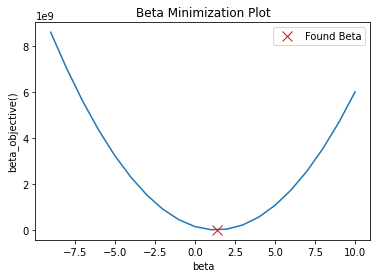

In [138]:
# Visualize Beta minimization
nearby_betas = []
nearby_beta_results = []

nearby_beta_limit = 10
for nearby_beta in range(int(beta) - nearby_beta_limit, int(beta) + nearby_beta_limit):
    # Check if local minimum equals global minimum
    nearby_betas.append(nearby_beta)
    nearby_beta_results.append(beta_objective(nearby_beta, beta_origin_constants, beta_destination_constants))

fig = plt.figure()

plt.plot(nearby_betas, nearby_beta_results, label="")
plt.plot(beta, beta_objective(beta, beta_origin_constants, beta_destination_constants),
         label="Found Beta", color='red', marker='x', markersize="10", linewidth=0)

plt.title(f"Beta Minimization Plot")
plt.xlabel("beta")
plt.ylabel("beta_objective()")
plt.legend(loc="upper right")

plt.show()

### 2.3 Create d_flow

In [139]:
d_flow = []

for od_data in d_merged_data:
    beta_scaled_flow = od_data[3] * beta
    new_od_data = (od_data[0], od_data[1], str(od_data[2])[:-3], beta_scaled_flow)
    d_flow.append(new_od_data)

assert len(d_flow) == len(d_merged_data)

In [140]:
d_flow_dataframe = pd.DataFrame(d_flow, columns=['CentroidID_O', 'CentroidID_D', 'dt_15', 'counts'])
d_flow_dataframe

,CentroidID_O,CentroidID_D,dt_15,counts
0,ext_1,int_0,14:00,2.904623
1,ext_10,int_0,14:00,9.075543
2,ext_4,int_0,14:00,2.926549
3,ext_6,int_0,14:00,5.742926
4,ext_7,int_0,14:00,1.539133
...,...,...,...,...
22015,ext_10,ext_6,19:45,0.000000
22016,ext_10,ext_7,19:45,0.000000
22017,ext_10,ext_8,19:45,0.000000
22018,ext_10,ext_9,19:45,0.000000


In [141]:
d_flow_ext = d_flow_dataframe[
    d_flow_dataframe['CentroidID_O'].str.contains('ext') & d_flow_dataframe['CentroidID_D'].str.contains('ext')]
d_flow_int = d_flow_dataframe[
    d_flow_dataframe['CentroidID_O'].str.contains('int') | d_flow_dataframe['CentroidID_D'].str.contains('int')]

In [142]:
d_flow_internal_total = d_flow_int['counts'].sum()
d_flow_external_total = d_flow_ext['counts'].sum()
traveler_resident_ratio_d_flow = d_flow_external_total / (d_flow_external_total + d_flow_internal_total)

<a id='export'></a>

# 3. Export Calibrated OD Demand Matrix

<a id='output_format'></a>
## Output Format

One .pkl file containing the flow-calibrated OD matrix from all centroids to all another centroid.

Note: The **centroid_name** should be unique & consistent with ids in `centroid_connections.pkl`

| Data                      | Description                              | Note                    |
|:--------------------------|:-----------------------------------------|:------------------------|
| od_demand_{year}.pkl | One pickle file (.pkl) containing: <br> **OriginDestinationMatrices** Object for Calibrated OD Demand | See `Utils/aimsun_input_utils.py` [(link)](https://github.com/Fremont-project/whole-code-repo/blob/53e9a289199ca825b1761293ceeb3737d1f2e848/Utils/aimsun_input_utils.py#L298) for class documentation |

#### Set up dependencies for export

In [16]:
# Import file under /Utils/
module_path = os.path.abspath(os.path.join('..', '..', 'Utils'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from aimsun_input_utils import (
    ExternalId,
    OriginDestinationTripsCount,
    OriginDestinationMatrix, 
    OriginDestinationMatrices,
    VehicleTypeName
)

# Set Export Path
export_path_calibrated = aimsun_folder_utils.od_demand_aimsun_input_file()
print(f'Export path set to: {export_path_calibrated}')

Export path set to: ../fremont-public-data/aimsun/inputs/demand/od_demand_2019.pkl


#### Convert d_flow data to OriginDestinationMatrices object

In [17]:
# Helper function to create OriginDestinationMatrices out of the given Grouped OD Demand DataFrame.
def create_OriginDestinationMatrices(od_dataframe: pd.DataFrame, vehicle_type_name: str):
    # Create a list of OriginDestinationMatrix objects as od_matrices_list 
    od_matrices_list = []

    # Group internal OD data by timestamp
    od_data_list = create_timeframe_grouped_od_matrices(od_dataframe)

    for od_data in od_data_list:
        # Create OriginDestinationMatrix object
        od_matrix = aimsun_input_utils.OriginDestinationMatrix()

        # Assign start and end timestamps
        start_time_dt = datetime.datetime.strptime(od_data['dt_15'][od_data.index[0]], '%H:%M')
        end_time_dt = start_time_dt + datetime.timedelta(minutes=15)
        od_matrix.begin_time_interval = start_time_dt.time()
        od_matrix.end_time_interval = end_time_dt.time()

        # Assign vehicle type
        od_matrix.vehicle_type = aimsun_input_utils.VehicleTypeName(vehicle_type_name)

        # Create and assign OD trip counts
        od_trips_list = []
        for i in od_data.index:
            od_trip = aimsun_input_utils.OriginDestinationTripsCount()
            od_trip.origin_centroid_external_id = aimsun_input_utils.ExternalId(od_data['CentroidID_O'][i])
            od_trip.destination_centroid_external_id = aimsun_input_utils.ExternalId(od_data['CentroidID_D'][i])
            od_trip.num_trips = float(od_data['counts'][i])
            od_trips_list.append(od_trip)
        od_matrix.od_trips_count = od_trips_list

        # Add OriginDestinationMatrix to int_od_matrices
        od_matrices_list.append(od_matrix)
    
    # Create Internal OriginDestinationMatrices object
    od_matrices_object = aimsun_input_utils.OriginDestinationMatrices()
    od_matrices_object.od_matrices = od_matrices_list
    
    return od_matrices_object


# Helper function to group OD demand data by timestamp. Returns a list of DataFrames that has the number of
# non-zero trips between each Origin -> Destination Centroid ID pairs for every timestamp (15 minutes).
def create_timeframe_grouped_od_matrices(od_dataframe: pd.DataFrame):
    grouped_od_data = od_dataframe.groupby(['dt_15'])
    timeframe_grouped_od_data_list = []
    for key, _ in grouped_od_data:
        timeframe_grouped_od_data_list.append(grouped_od_data.get_group(key))
    return timeframe_grouped_od_data_list

In [18]:
# Quick test for column names
assert list(d_flow_ext.columns) == ['CentroidID_O', 'CentroidID_D', 'dt_15', 'counts']
assert list(d_flow_int.columns) == ['CentroidID_O', 'CentroidID_D', 'dt_15', 'counts']

calibrated_int_od_matrices = create_OriginDestinationMatrices(d_flow_int, 'Resident')
calibrated_ext_od_matrices = create_OriginDestinationMatrices(d_flow_ext, 'Traveler')

In [19]:
# Test correctness of Internal OriginDestinationMatrices object.
int_to_int_exists = False

for od_matrix in calibrated_int_od_matrices.od_matrices:
    for od_trip in od_matrix.od_trips_count:
        if ('int' in od_trip.origin_centroid_external_id[0:3]
                and 'int' in od_trip.destination_centroid_external_id[0:3]):
            int_to_int_exists = True
        if ('ext' in od_trip.origin_centroid_external_id[0:3]
                and 'ext' in od_trip.destination_centroid_external_id[0:3]):
            raise TypeError(f"Error: Ext -> Ext OD Demand is inside OD Demand as internal demand.")

assert int_to_int_exists == True

# Test correctness of External OriginDestinationMatrices object.
for od_matrix in calibrated_ext_od_matrices.od_matrices:
    for od_trip in od_matrix.od_trips_count:
        if (not 'ext' in od_trip.origin_centroid_external_id
                or not 'ext' in od_trip.destination_centroid_external_id):
            raise TypeError(f"Error: NOT Ext -> Ext OD Demand is inside OD Demand as external demand.")

In [20]:
calibrated_od_demand = aimsun_input_utils.OriginDestinationMatrices()

# Join Internal and External Demand into one object
joined_od_matrices = []
for _, int_od_matrix in enumerate(calibrated_int_od_matrices.od_matrices):
    joined_od_matrices.append(int_od_matrix)
for _, ext_od_matrix in enumerate(calibrated_ext_od_matrices.od_matrices):
    joined_od_matrices.append(ext_od_matrix)
calibrated_od_demand.od_matrices = joined_od_matrices

In [21]:
# Test that int-int demand are not all the same.
int_to_int_demand_list = []
for od_matrix in calibrated_od_demand.od_matrices:
    for od_trip in od_matrix.od_trips_count:
        int_to_int_demand_list.append(od_trip.num_trips)

assert len(int_to_int_demand_list) > 0 and not all(d == int_to_int_demand_list[0] for d in int_to_int_demand_list)

#### Export object

In [22]:
# Export calibrated OD Demand object
calibrated_od_demand.export_to_file(export_path_calibrated)
f"File saved to {export_path_calibrated}"

'File saved to ../fremont-public-data/aimsun/inputs/demand/od_demand_2019.pkl'